In [3]:
import pandas as pd

try:
    df = pd.read_csv('gs://rob_buck/loan.csv', low_memory=False)
    print("The dataframe has been loaded successfully!")
except Exception as e:
    print(f"There was an error loading the file\nError: {e}")

/var/tmp/ipykernel_98315/1735819587.py:4: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('gs://rob_buck/loan.csv')


The dataframe has been loaded successfully!


In [4]:
df.shape

(2260668, 145)

In [5]:
df['is_default'] = df['loan_status'].map({
    'Fully Paid': 0,
    'Current': 0,
    'In Grace Period': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    
    'Charged Off': 1,
    'Default': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Charged Off': 1
})

In [6]:
key_features = [
    'loan_amnt',           # Loan amount
    'int_rate',            # Interest rate  
    'grade',               # LC grade (A-G)
    'annual_inc',          # Annual income
    'dti',                 # Debt-to-income ratio
    'delinq_2yrs',         # Delinquencies in past 2 years
    'revol_util',          # Credit utilization
    'emp_length',          # Employment length
    'home_ownership',      # Home ownership status
    'purpose',             # Loan purpose
    'is_default'            
]

In [7]:
df = df[key_features]

In [8]:
df.shape

(2260668, 11)

In [9]:
df.isnull().sum() 

loan_amnt              0
int_rate               0
grade                  0
annual_inc             4
dti                 1711
delinq_2yrs           29
revol_util          1802
emp_length        146907
home_ownership         0
purpose                0
is_default             0
dtype: int64

In [10]:
df['annual_inc'] = df['annual_inc'].fillna(df['annual_inc'].mean())
df['dti'] = df['dti'].fillna(df['dti'].median())
df['delinq_2yrs'] = df['delinq_2yrs'].fillna(df['delinq_2yrs'].median())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())
df['emp_length'] = df['emp_length'].fillna('Unknown')

In [11]:
df.isnull().sum() 

loan_amnt         0
int_rate          0
grade             0
annual_inc        0
dti               0
delinq_2yrs       0
revol_util        0
emp_length        0
home_ownership    0
purpose           0
is_default        0
dtype: int64

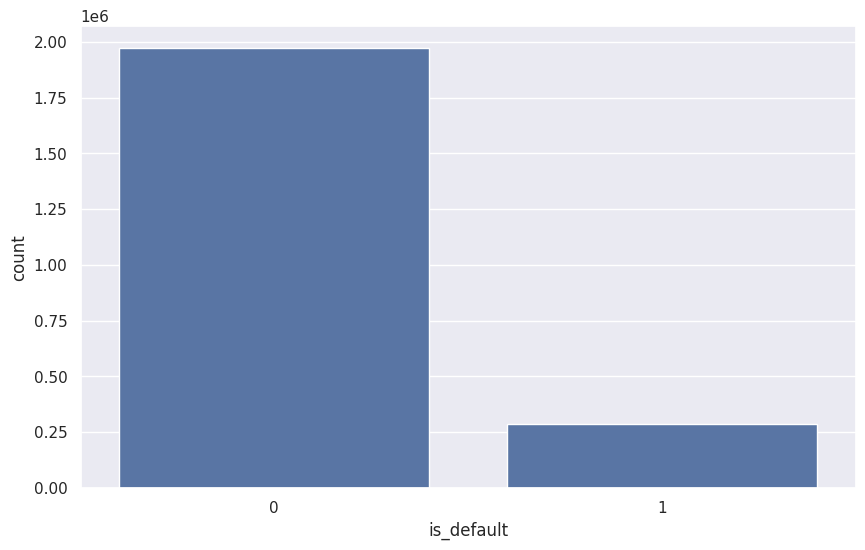

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 6))

sns.countplot(data=df, x=df['is_default'])
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder

# OneHot encode categorical columns directly
for col in ['grade', 'emp_length', 'home_ownership', 'purpose']:
   encoder = LabelEncoder()
   df[col] = encoder.fit_transform(df[col])

df.head()

,loan_amnt,int_rate,grade,annual_inc,dti,delinq_2yrs,revol_util,emp_length,home_ownership,purpose,is_default
0,2500,13.56,2,55000.0,18.24,0.0,10.3,1,5,2,0
1,30000,18.94,3,90000.0,26.52,0.0,24.2,1,1,2,0
2,5000,17.97,3,59280.0,10.51,0.0,19.1,6,1,2,0
3,4000,18.94,3,92000.0,16.74,0.0,78.1,1,1,2,0
4,30000,16.14,2,57250.0,26.35,0.0,3.6,1,1,2,0


In [14]:
df.columns

Index(['loan_amnt', 'int_rate', 'grade', 'annual_inc', 'dti', 'delinq_2yrs',
       'revol_util', 'emp_length', 'home_ownership', 'purpose', 'is_default'],
      dtype='object')

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('is_default', axis=1), df['is_default'], test_size=0.2, random_state=42)

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (1808534, 10)
X_test_scaled shape: (452134, 10)


In [18]:
from scipy.stats import uniform, randint

param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(300, 2000),
    'max_depth': randint(6, 20),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'colsample_bylevel': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 10),
    'reg_lambda': uniform(1, 10),
    'gamma': uniform(0, 5),
    'scale_pos_weight': uniform(7, 12),  # Around your 9:1 ratio
}

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # Better for large datasets
)

In [20]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,  
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

In [ ]:
random_search.fit(X_train_scaled, y_train)

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
print("Best parameters:", random_search.best_params_)
print("\nBest cross-validation score:", random_search.best_score_)

In [ ]:
model = random_search.best_estimator_

In [ ]:
pred = model.predict(X_test_scaled)
pred_proba = model.predict_proba(X_test_scaled)[: , 1]

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

acc = accuracy_score(y_test, pred)
print(f"Accuracy: {acc:.4f}")

auc = roc_auc_score(y_test, pred_proba)
print(f"ROC: {auc:.4f}")
